# Feasibility and Impact of Converting UA's Surface Parking to Solar Power
## Final Project for ME-591

Max Schrader

## Solar Potential Calculation 

### Decide on a Brand

Once I decide on a brand, I need to determine the solar efficiency of the panels. 

I should also calculate the installation price and determine if there are federal credits available

I reached out to sunpower, should give me ballpark on installation price and which panels they would recommend

Also they should tell me the optimal facing

### Determine the installed capabilities

### Simplistic, from the book

In [32]:
import pint
import math
import numpy as np
import pandas as pd
import pint_pandas
import atlite
import logging
import geopandas as gpd
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "ggplot2"
pio.renderers.default = "plotly_mimetype"
logging.basicConfig(level=logging.INFO)
ureg = pint.UnitRegistry(autoconvert_offset_to_baseunit = True)
pint_pandas.PintType.ureg = ureg

#### Average Daily Solar Radiation on a Horizontal Surface in Selected Cities in the United States

Given in $\frac{MJ}{m^2 \cdot day}$

In [2]:
G_solar = list(map(lambda x: x * ureg.MJ / (ureg.m ** 2 * ureg.day), [9.20, 11.92, 13.67, 19.65, 21.58, 22.37, 21.24, 20.21, 17.15, 14.42, 10.22, 8.40]))
G_solar = {i + 1: {'G': g, 'D': (30 if i % 2 else 31) * ureg.day} for i, g in enumerate(G_solar)}
# Manually Correcting Feb. Days
G_solar[2]['D'] = 28 * ureg.day

In [3]:
G_solar

{1: {'G': 9.2 <Unit('megajoule / day / meter ** 2')>, 'D': 31 <Unit('day')>},
 2: {'G': 11.92 <Unit('megajoule / day / meter ** 2')>, 'D': 28 <Unit('day')>},
 3: {'G': 13.67 <Unit('megajoule / day / meter ** 2')>, 'D': 31 <Unit('day')>},
 4: {'G': 19.65 <Unit('megajoule / day / meter ** 2')>, 'D': 30 <Unit('day')>},
 5: {'G': 21.58 <Unit('megajoule / day / meter ** 2')>, 'D': 31 <Unit('day')>},
 6: {'G': 22.37 <Unit('megajoule / day / meter ** 2')>, 'D': 30 <Unit('day')>},
 7: {'G': 21.24 <Unit('megajoule / day / meter ** 2')>, 'D': 31 <Unit('day')>},
 8: {'G': 20.21 <Unit('megajoule / day / meter ** 2')>, 'D': 30 <Unit('day')>},
 9: {'G': 17.15 <Unit('megajoule / day / meter ** 2')>, 'D': 31 <Unit('day')>},
 10: {'G': 14.42 <Unit('megajoule / day / meter ** 2')>,
  'D': 30 <Unit('day')>},
 11: {'G': 10.22 <Unit('megajoule / day / meter ** 2')>,
  'D': 31 <Unit('day')>},
 12: {'G': 8.4 <Unit('megajoule / day / meter ** 2')>, 'D': 30 <Unit('day')>}}

#### Calculating the Surface Area Available   

Using Google Maps, I calculated the surface area of all the considered parking lots

In [4]:
parking_lots = pd.read_csv("ParkingLotArea.csv")
parking_lots.head()

,Lot,Area (ft),Parking Group,Parking Spots,Lat,Lon
0,NE of NE Commuter,234753.94,NE Commuter,NaN,33.214818,-87.532654
1,Cent. of NE Commuter,206558.77,NE Commuter,NaN,33.214818,-87.532654
2,S of NE Commuter,112735.93,NE Commuter,NaN,33.213234,-87.533540
3,Frat of NE Commuter,283463.92,NE Commuter,NaN,33.209185,-87.533937
4,Cyber Hall Parking,97977.49,Faculty,NaN,33.220687,-87.537042


In [5]:
parking_lots['Area (ft)'] = parking_lots['Area (ft)'].astype("pint[ft^2]")

#### Calculating the Theoretical Energy per Day

In [6]:
N_pv = 0.19 # the efficiency of SunPower P-series 

In [7]:
for month, inner_dict in G_solar.items():
    parking_lots[f'P_{month}'] = (parking_lots['Area (ft)']* N_pv * inner_dict['G']).pint.to("MJ / day")

##### Average Daily per Lot and Total

In [8]:
parking_lots['P_avg'] = 0 
parking_lots['P_avg'] = parking_lots['P_avg'].astype('pint[MJ / day]') 

for month, inner_dict in G_solar.items():
    parking_lots['P_avg'] += parking_lots[f'P_{month}'] * inner_dict['D'] / (365 * ureg.day)

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pint_pandas/pint_array.py:194: RuntimeWarning: pint-pandas does not support magnitudes of <class 'numpy.int64'>. Converting magnitudes to float.
  warnings.warn(


In [9]:
parking_lots['P_total'] = (parking_lots['P_avg'] * 365 * ureg.day)

#### Calculating the installed capacity, using the area and Sun Power's Datasheet

https://us.sunpower.com/sites/default/files/media-library/data-sheets/ds-sunpower-p17-355-1500v-commercial-solar-panels.pdf

The installed capacity is for use below, and thus is not the actually capacity. It is the upper limit of what is possible

In [10]:
P_pv = 355 * ureg.watt
A_pv = 81.4 * 39.3 * ureg.inch ** 2
N_ac_dc = .9
N_area = 0.95  # estimating that not all surface area will be covered by panels due to geometry constraints etc.

##### Determining the number of SunPower P17 Panels that can fit on each surface

Used https://pvwatts.nrel.gov/pvwatts.php as a check and it confirms the estimate

In [11]:
parking_lots['# of Panels'] = (parking_lots['Area (ft)'] / A_pv * N_area).pint.to('dimensionless')
parking_lots['# of Panels'] = np.floor(parking_lots['# of Panels'])
parking_lots['# of Panels']

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


0    10038
1     8833
2     4820
3    12121
4     4189
5     4910
6     5730
7     7924
8     9089
9     5600
Name: # of Panels, dtype: object

In [12]:
parking_lots['PV Capacity'] = parking_lots['# of Panels'] * P_pv * N_ac_dc
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].astype('pint[W]')
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].pint.to('MW')
parking_lots['PV Capacity']

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pandas/core/construction.py:564: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


0              3.207141
1    2.8221434999999997
2               1.53999
3    3.8726594999999997
4             1.3383855
5    1.5687449999999998
6              1.830735
7    2.5317179999999997
8             2.9039355
9                1.7892
Name: PV Capacity, dtype: pint[megawatt]

In [13]:
parking_lots['PV Capacity'].sum()

23.404653 <Unit('megawatt')>

## Complicated Capacity Estimate

In [14]:
bl = 32.988320041698074, -87.79145924201974
tr = 33.473235950702524, -87.32768306322347

#### Using the ERA5 Dataset

In [17]:
cutout = atlite.Cutout(path="Alabama.nc",
                       module="era5",
                       x=slice(bl[1], tr[1]),
                       y=slice(bl[0], tr[0]),
                       time="2015"  # "2018-12")
                       )

INFO:atlite.cutout:Building new cutout Alabama.nc


In [18]:
cutout.prepare()

INFO:atlite.data:Storing temporary files in /var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/tmpevy89s_d
INFO:atlite.data:Calculating and writing with module era5:
INFO:atlite.datasets.era5:Requesting data for feature wind...
INFO:atlite.datasets.era5:Requesting data for feature temperature...
INFO:atlite.datasets.era5:Requesting data for feature height...
INFO:atlite.datasets.era5:CDS: Downloading variables
	 * geopotential (2015)

INFO:atlite.datasets.era5:CDS: Downloading variables                                                                                                                                                                                                                         
	 * 2m_temperature (2015)
	 * soil_temperature_level_4 (2015)

INFO:atlite.datasets.era5:Requesting data for feature runoff...
INFO:atlite.datasets.era5:CDS: Downloading variables                                                                                                                  

[########################################] | 100% Completed |  1.4s


<Cutout "Alabama">
 x = -87.75 ⟷ -87.50, dx = 0.25
 y = 33.00 ⟷ 33.25, dy = 0.25
 time = 2015-01-01 ⟷ 2015-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [19]:
cells = gpd.GeoDataFrame({'geometry': cutout.grid_cells,
                          'lon': cutout.grid_coordinates()[:,0],
                          'lat': cutout.grid_coordinates()[:,1]})

In [20]:
nearest_cell = cutout.data.sel({'x': parking_lots.Lon.values,
                                'y': parking_lots.Lat.values},
                               'nearest').coords

In [21]:
# Map capacities to closest cell coordinate
parking_lots['lon'] = nearest_cell.get('lon').values
parking_lots['lat'] = nearest_cell.get('lat').values

In [22]:
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].pint.magnitude

In [23]:
new_data = parking_lots.merge(cells, how='inner')

# Sum capacities for each grid cell (lat, lon)
# then: restore lat lon as coumns
# then: rename and reindex to match cutout coordinates
new_data = new_data.groupby(['lon','lat']).sum()

layout = new_data.reset_index().rename(columns={'lat':'y','lon':'x'})\
                    .set_index(['y','x'])['PV Capacity']\
                    .to_xarray().reindex_like(cutout.data)

layout = layout.fillna(.0).rename('Installed Capacity [MW]')

In [24]:
pv = cutout.pv(panel="CSi", orientation='latitude_optimal', layout=layout)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [ ]:
# pv.squeeze()

In [28]:
pv.squeeze().to_series().index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=8760, freq=None)

### Plotting Solar

#### Average Weekly Power

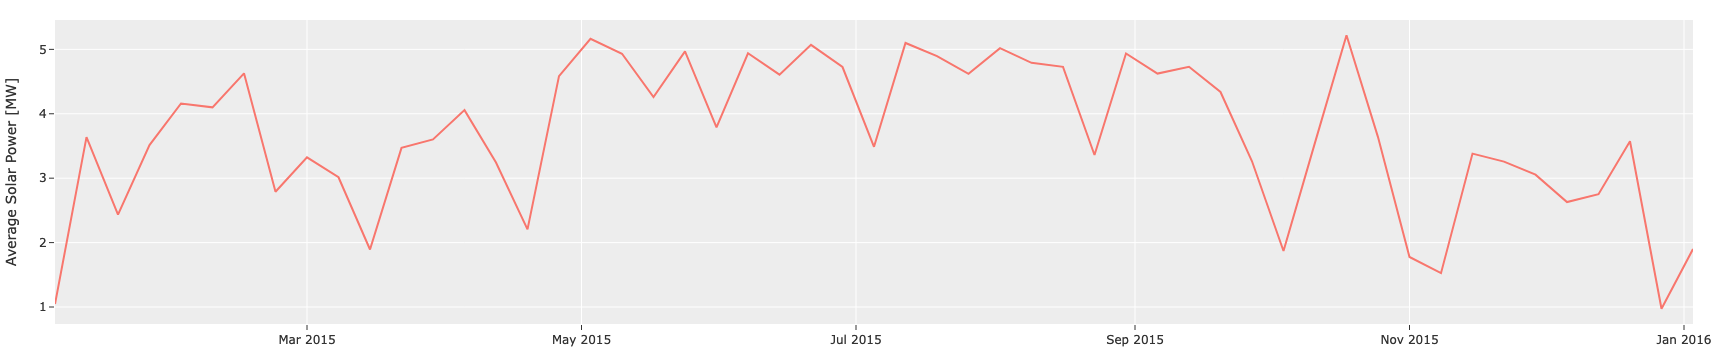

In [38]:
fig = go.Figure()
weekly = pv.squeeze().to_series().resample('1W').mean()
fig.add_trace(go.Scatter(x=weekly.index, y=weekly.values))
fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Average Solar Power [MW]",
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

### Daily in May

In [40]:
atlite_solar_power = pv.squeeze().to_series()

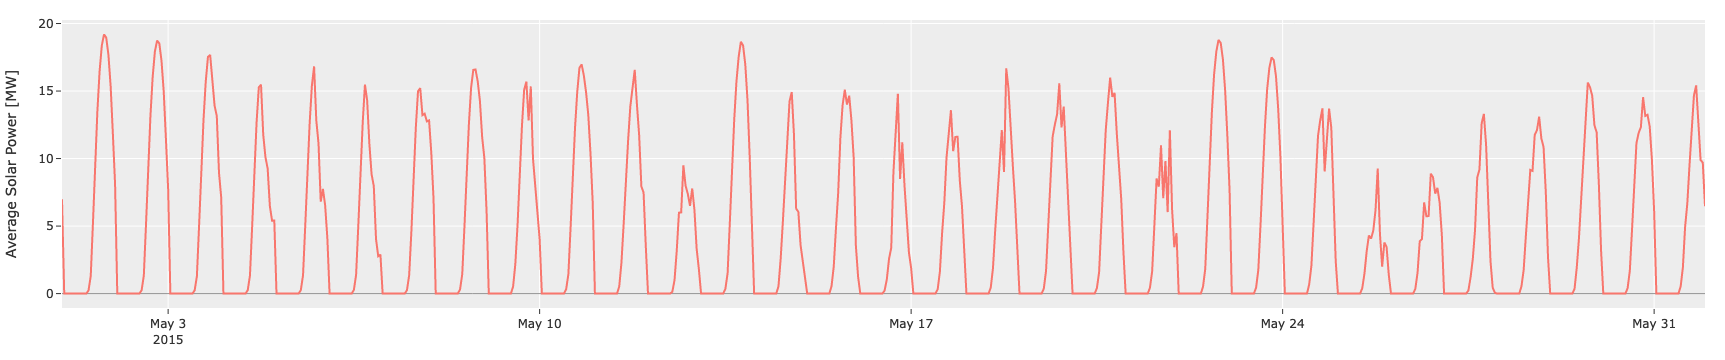

In [43]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=atlite_solar_power.loc[atlite_solar_power.index.month == 5].index, y=atlite_solar_power.loc[atlite_solar_power.index.month == 5].values))
fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Average Solar Power [MW]",
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

### Hydro Battery Calculations

Flow: https://water.weather.gov/ahps2/hydrograph.php?wfo=bmx&gage=toda1


In [44]:
pres_elevation = 213 * ureg.ft
river_elevation = 123 * ureg.ft
river_flow = 2 * 1000 * ureg.ft * 3 / ureg.second  # given in kcfs

#### Necessary Power

Assuming that the turbine is 90 percent efficient, that the generator in 96% efficient, and that the headloss is ~2% of the total dh 


In [60]:
density_water = 1000 * ureg.kg / ureg.m ** 3

P_desired = 5 * ureg.MW
E_desired = P_desired * 10 * 3600 * ureg.second

N_gen = 0.96
N_turbine = 0.9

HL = (pres_elevation - river_elevation) * (0.02)


#### Determine the necessary flow rate

In [61]:
P_water = P_desired / N_gen / N_turbine
P_water

5.787037037037037 <Unit('megawatt')>

In [64]:
m_water = (P_water / ((pres_elevation - river_elevation - HL) * ureg.gravity * density_water)).to('ft^3 / s')
m_water

775.1881951148223 <Unit('foot ** 3 / second')>

#### Necessary Storage Volume

In [66]:
((E_desired / P_desired) * m_water / 50 / np.pi)**(1/2)

421.49738745782565 <Unit('foot ** 1.5')>

#### Computing the installed cost

https://www.irena.org/costs/Power-Generation-Costs/Hydropower

In [93]:
C_p = 4500 / ureg.kW
cost_hydro = P_desired * C_p
cost_hydro = cost_hydro.to('dimensionless')
cost_hydro

22500000.0 <Unit('dimensionless')>

## Total Cost Analysis

For comparision https://buildingbama.ua.edu/projects/new-tutwiler-residence-hall/ costs $144,900,659.00

### Solar

https://www.eia.gov/todayinenergy/detail.php?id=36813

In [74]:
parking_lots['PV Capacity'].sum()

23.404653

In [94]:
C_solar = 2921 / ureg.kW
cost_solar = parking_lots['PV Capacity'].sum() * ureg.MW * C_solar
cost_solar = cost_solar.to('dimensionless')
cost_solar

68364991.413 <Unit('dimensionless')>

### Cost of Electricity

In [86]:
c_p_kwh = 13.53 / 100 / ureg.kWh   # 13.53 cents per kWh per https://www.chooseenergy.com/electricity-rates-by-state/
# c_resale_kwh = 

### For the sake of simplicity, lets say that UA simply consumes the area under the solar curve

In [87]:
yearly_elec = np.trapz(pv.squeeze().to_series().values, dx=3600) * ureg.MW * ureg.second

In [88]:
yearly_elec.to('kWh') * c_p_kwh

4407278.904662651 <Unit('dimensionless')>

## Cost Benefit Analysis

In [95]:
cost_solar + cost_hydro

90864991.413 <Unit('dimensionless')>

### Payback Period